In [1]:
import os
import random
from pathlib import Path
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
import torchaudio
import logging
from copy import deepcopy
import csv
from typing import Callable, List, Optional, Tuple, Union
from collections import OrderedDict


### Utils

def find_wav_files(path_to_dir: Union[Path, str]) -> Optional[List[Path]]:
    """Find all wav files in the directory and its subtree.

    Args:
        path_to_dir: Path top directory.
    Returns:
        List containing Path objects or None (nothing found).
    """
    paths = list(sorted(Path(path_to_dir).glob("**/*.wav")))

    if len(paths) == 0:
        return None
    return paths


def set_seed(seed: int):
    """Fix PRNG seed for reproducable experiments.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            directory_or_path_list: Union[Union[str, Path], List[Union[str, Path]]],
            sample_rate: int = 16_000,
            normalize: bool = True,
            real: str = 'real',
    ) -> None:
        super().__init__()

        self.sample_rate = sample_rate
        self.normalize = normalize
        if real == 'real':
            directory_or_path_list = directory_or_path_list * 5

        if isinstance(directory_or_path_list, list):
            paths = directory_or_path_list
        elif isinstance(directory_or_path_list, Path) \
                or isinstance(directory_or_path_list, str):
            directory = Path(directory_or_path_list)
            if not directory.exists():
                raise IOError(f"Directory does not exists: {self.directory}")

            paths = find_wav_files(directory)
            if paths is None:
                raise IOError(
                    f"Directory did not contain wav files: {self.directory}")
        else:
            raise TypeError(
                f"Supplied unsupported type for argument directory_or_path_list {type(directory_or_path_list)}!")


        self._paths = paths

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        path = self._paths[index]

        waveform, sample_rate = torchaudio.load(path, normalize=self.normalize)

        if sample_rate != self.sample_rate:
            transform = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = transform(waveform)


        return waveform, sample_rate

    def __len__(self) -> int:
        return len(self._paths)


class PadDataset(torch.utils.data.Dataset):

    def __init__(self, dataset: torch.utils.data.Dataset, cut: int = 64600, label=None):
        self.dataset = dataset
        self.cut = cut  # max 4 sec (ASVSpoof default)
        self.label = label

    def __getitem__(self, index):
        waveform, sample_rate = self.dataset[index]
        waveform = waveform.squeeze(0)
        waveform_len = waveform.shape[0]
        if waveform_len >= self.cut:
            if self.label is None:
                return waveform[:self.cut], sample_rate
            else:
                return waveform[:self.cut], sample_rate, self.label
        # need to pad
        num_repeats = int(self.cut / waveform_len)+1
        padded_waveform = torch.tile(waveform, (1, num_repeats))[
            :, :self.cut][0]

        if self.label is None:
            return padded_waveform, sample_rate
        else:
            return padded_waveform, sample_rate, self.label

    def __len__(self):
        return len(self.dataset)




def load_dataset(
        path: Union[Path, str],
        pad: bool = False,
        train: str = 'train',
        real: str = 'real',
        label: Optional[int] = None,
) -> Tuple[torch.utils.data.Dataset]:

    cur_path = "{}/{}/{}".format(path,train,real)
    
    paths = find_wav_files(cur_path)
    if paths is None:
        raise IOError(f"Could not load files from {path}!")

    LOGGER.info(f"Loading data from {path}...!")

    train_dataset = AudioDataset(
        paths, real=real)
    if pad:
        train_dataset = PadDataset(train_dataset, label=label)

    return train_dataset




def load_dataset_test(
        path: Union[Path, str],
        pad: bool = True,
) -> Tuple[torch.utils.data.Dataset]:


    paths = find_wav_files(path)
    if paths is None:
        raise IOError(f"Could not load files from {path}!")


    test_dataset = AudioDataset(
        paths, real='fake')
    if pad:
        test_dataset = PadDataset(test_dataset, label=0)

    return test_dataset

In [3]:
# raw_Net2

class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):

        super(SincConv,self).__init__()

        if in_channels != 1:
            
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)
        
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device=device   
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')
        
        
        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)
        fmel=self.to_mel(f)   # Hz to mel conversion
        fmelmax=np.max(fmel)
        fmelmin=np.min(fmel)
        filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+1)
        filbandwidthsf=self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel=filbandwidthsf
        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels,self.kernel_size)
    
       
        
    def forward(self,x):
        for i in range(len(self.mel)-1):
            fmin=self.mel[i]
            fmax=self.mel[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow
            
            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)
        
        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)
        
        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)


        
class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.3)
        
        self.conv1 = nn.Conv1d(in_channels = nb_filts[0],
			out_channels = nb_filts[1],
			kernel_size = 3,
			padding = 1,
			stride = 1)
        
        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1],
			out_channels = nb_filts[1],
			padding = 1,
			kernel_size = 3,
			stride = 1)
        
        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0],
				out_channels = nb_filts[1],
				padding = 0,
				kernel_size = 1,
				stride = 1)
            
        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)
        
    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(x)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        
        if self.downsample:
            identity = self.conv_downsample(identity)
            
        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        
        self.device=device

        self.Sinc_conv=SincConv(device=self.device,
			out_channels = d_args['filts'][0],
			kernel_size = d_args['first_conv'],
                        in_channels = d_args['in_channels']
        )
        
        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)

        
        self.block0 = Residual_block(nb_filts = d_args['filts'][1], first = True)
        self.block1 = Residual_block(nb_filts = d_args['filts'][1])
        self.block2 = Residual_block(nb_filts = d_args['filts'][2])
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = Residual_block(nb_filts = d_args['filts'][2])
        self.block4 = Residual_block(nb_filts = d_args['filts'][2])
        self.block5 = Residual_block(nb_filts = d_args['filts'][2])
        self.block6 = Residual_block(nb_filts = d_args['filts'][2])
        self.block7 = Residual_block(nb_filts = d_args['filts'][2])
        self.block8 = Residual_block(nb_filts = d_args['filts'][2])
        # self.block9 = Residual_block(nb_filts = d_args['filts'][2])
        # self.block10 = Residual_block(nb_filts = d_args['filts'][2])
        # self.block11 = Residual_block(nb_filts = d_args['filts'][2])
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention6 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention7 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention8 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        # self.fc_attention9 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
        #     l_out_features = d_args['filts'][2][-1])
        # self.fc_attention10 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
        #     l_out_features = d_args['filts'][2][-1])
        # self.fc_attention11 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
        #     l_out_features = d_args['filts'][2][-1])
        

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1],
			hidden_size = d_args['gru_node'],
			num_layers = d_args['nb_gru_layer'],
			batch_first = True)
        
        
        self.dropout_fc1 = nn.Dropout(p=0.3)  # 첫 번째 완전 연결층 후 드롭아웃
        self.dropout_fc2 = nn.Dropout(p=0.3)

       
        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'],
			out_features = d_args['nb_fc_node'])
       
        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'],
			out_features = d_args['nb_classes'],bias=True)
			
       
        self.sig = nn.Sigmoid()
        
    def forward(self, x, y = None):
        
        
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)
        
        x = self.Sinc_conv(x)    
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x =  self.selu(x)
        
        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)
        

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x6 = self.block6(x)
        y6 = self.avgpool(x6).view(x6.size(0), -1) # torch.Size([batch, filter])
        y6 = self.fc_attention6(y6)
        y6 = self.sig(y6).view(y6.size(0), y6.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x6 * y6 + y6 # (batch, filter, time) x (batch, filter, 1)

        x7 = self.block7(x)
        y7 = self.avgpool(x7).view(x7.size(0), -1) # torch.Size([batch, filter])
        y7 = self.fc_attention7(y7)
        y7 = self.sig(y7).view(y7.size(0), y7.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x7 * y7 + y7 # (batch, filter, time) x (batch, filter, 1)

        x8 = self.block8(x)
        y8 = self.avgpool(x8).view(x8.size(0), -1) # torch.Size([batch, filter])
        y8 = self.fc_attention8(y8)
        y8 = self.sig(y8).view(y8.size(0), y8.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x8 * y8 + y8 # (batch, filter, time) x (batch, filter, 1)

        # x9 = self.block9(x)
        # y9 = self.avgpool(x9).view(x9.size(0), -1) # torch.Size([batch, filter])
        # y9 = self.fc_attention9(y9)
        # y9 = self.sig(y9).view(y9.size(0), y9.size(1), -1)  # torch.Size([batch, filter, 1])
        # x = x9 * y9 + y9 # (batch, filter, time) x (batch, filter, 1)

        # x10 = self.block10(x)
        # y10 = self.avgpool(x10).view(x10.size(0), -1) # torch.Size([batch, filter])
        # y10 = self.fc_attention10(y10)
        # y10 = self.sig(y10).view(y10.size(0), y10.size(1), -1)  # torch.Size([batch, filter, 1])
        # x = x10 * y10 + y10 # (batch, filter, time) x (batch, filter, 1)
        
        # x11 = self.block11(x)
        # y11 = self.avgpool(x11).view(x11.size(0), -1) # torch.Size([batch, filter])
        # y11 = self.fc_attention11(y11)
        # y11 = self.sig(y10).view(y11.size(0), y11.size(1), -1)  # torch.Size([batch, filter, 1])
        # x = x11 * y11 + y11 # (batch, filter, time) x (batch, filter, 1)

        
        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        
        x = self.fc1_gru(x)
        x = self.dropout_fc1(x) 
        
        x = self.fc2_gru(x)
        x = self.dropout_fc2(x)  # 두 번째 드롭아웃 적용

        output = x.softmax(dim=1)
        return output


    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))
        return nn.Sequential(*l_fc)


In [4]:
class Trainer(object):
    def __init__(self,
                 epochs: int = 20,
                 batch_size: int = 32,
                 device: str = "cpu",
                 optimizer_fn: Callable = torch.optim.Adam,
                 optimizer_kwargs: dict = {"lr": 1e-3},
                 ) -> None:
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.optimizer_fn = optimizer_fn
        self.optimizer_kwargs = optimizer_kwargs
        self.epoch_test_losses: List[float] = []



class GDTrainer(Trainer):
    def train(self,
              dataset_train: torch.utils.data.Dataset,
              dataset_validation: torch.utils.data.Dataset,
              model: torch.nn.Module,
              model_dir: str,
              ):

        train_loader = DataLoader(
            dataset_train, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=4)
        validation_loader = DataLoader(
            dataset_validation, batch_size=self.batch_size, drop_last=True, num_workers=4)

        criterion = torch.nn.CrossEntropyLoss()
        optim = self.optimizer_fn(model.parameters(), **self.optimizer_kwargs)

        best_model = None
        best_acc = 0
        for epoch in range(self.epochs):
            running_loss = 0
            num_correct = 0.0
            num_total = 0.0
            model.train()

            for i, (batch_x, _, batch_y) in enumerate(train_loader):
                batch_size = batch_x.size(0)
                num_total += batch_size

                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                batch_out = model(batch_x)
                batch_loss = criterion(batch_out, batch_y)

                _, batch_pred = batch_out.max(dim=1)
                num_correct += (batch_pred == batch_y).sum(dim=0).item()


                running_loss += (batch_loss.item() * batch_size)
                
                if i % (train_loader.__len__() // 20) == 0:
                    cur_loss = batch_loss
                    LOGGER.info(f"[{epoch:04d}] {i}/{train_loader.__len__()}: {cur_loss}")

                optim.zero_grad()
                batch_loss.backward()
                optim.step()

            running_loss /= num_total
            train_accuracy = (num_correct/num_total)*100
            
            
            num_correct = 0.0
            num_total = 0.0
            model.eval()
            for batch_x, _, batch_y in validation_loader:

                batch_size = batch_x.size(0)
                num_total += batch_size
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                batch_out = model(batch_x)

                _, batch_pred = batch_out.max(dim=1)
                num_correct += (batch_pred == batch_y).sum(dim=0).item()

            valid_acc = 100 * (num_correct / num_total)

            if best_model is None or valid_acc > best_acc:
                best_acc = valid_acc
                best_model = deepcopy(model.state_dict())
                save_model(model, model_dir)

            LOGGER.info(
                f"[{epoch:04d}]: {running_loss} - train acc: {train_accuracy} - valid_acc: {valid_acc}")

        model.load_state_dict(best_model)
        return model
    
    def test(self,
              dataset_test: torch.utils.data.Dataset,
              model: torch.nn.Module,
              ):
        model.eval()
        test_loader = DataLoader(
            dataset_test, batch_size=1, drop_last=False)
        
        f = open('Original_ver2.csv', 'w', newline='')
        wr = csv.writer(f)
        wr.writerow(['Id', 'Predicted'])

        for i, (batch_x, _, batch_y) in enumerate(test_loader):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                batch_out = model(batch_x)

                _, batch_pred = batch_out.max(dim=1)

                wr.writerow([i+1, batch_pred[0].item()])
        f.close()


In [ ]:
LOGGER = logging.getLogger(__name__)

## Trainer
RAW_NET_CONFIG = {
    "nb_samp": 64600,
    "first_conv": 2048,   # no. of filter coefficients
    "in_channels": 1,  # no. of filters channel in residual blocks
    "filts": [32, [32, 32], [32, 128], [128, 256]],
    "blocks": [3, 6],
    "nb_fc_node": 2048,
    "gru_node": 2048,
    "nb_gru_layer": 4,
    "nb_classes": 2,
}




def init_logger(log_file):
    LOGGER.setLevel(logging.INFO)

    # create file handler
    fh = logging.FileHandler(log_file)

    # create console handler
    ch = logging.StreamHandler()

    # create formatter and add it to the handlers
    formatter = logging.Formatter(
        '%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    LOGGER.addHandler(fh)
    LOGGER.addHandler(ch)


def save_model(
        model: torch.nn.Module,
        model_dir: Union[Path, str],
) -> None:
    torch.save(model.state_dict(),
               f"{model_dir}/best.pth")


def train_raw_net(
        real_training_distribution: Union[Path, str],
        fake_training_distributions: List[Union[Path, str]],
        batch_size: int,
        epochs: int,
        device: str,
        test_dir: str,
        model_dir: Optional[str] = None,
) -> None:

    LOGGER.info("Loading data...")

    

    # real data
    real_dataset_train = load_dataset(
        real_training_distribution,
        pad=True,
        train='train',
        real='real',
        label=1,
    )

    real_dataset_validation = load_dataset(
        real_training_distribution,
        pad=True,
        train='validation',
        real='real',
        label=1,
    )

    LOGGER.info(f"Training {fake_training_distributions}")
    # fake data
    fake_dataset_train = load_dataset(
            fake_training_distributions,
            pad=True,
            train='train',
            real='fake',
            label=0,
        )

    fake_dataset_validation = load_dataset(
            fake_training_distributions,
            pad=True,
            train='validation',
            real='fake',
            label=0,
        )
    
    # test
    dataset_test = load_dataset_test(
            test_dir,
            pad=True,
        )


    current_model = RawNet(deepcopy(RAW_NET_CONFIG), device).to(device)
    data_train = ConcatDataset([real_dataset_train, fake_dataset_train])
    data_validation = ConcatDataset([real_dataset_validation, fake_dataset_validation])


    LOGGER.info(
            f"Training rawnet model on {len(data_train)} audio files.")
    
    current_model = GDTrainer(
            device=device,
            batch_size=batch_size,
            epochs=epochs,
            optimizer_kwargs={
                "lr": 0.0001,
                "weight_decay": 0.0001,
            }
        ).train(
            dataset_train=data_train,
            dataset_validation=data_validation,
            model=current_model,
            model_dir=model_dir,
        )


    LOGGER.info("Training is done!")

    #Test
    GDTrainer(
            device=device,
            batch_size=batch_size,
            epochs=epochs,
            optimizer_kwargs={
                "lr": 0.0001,
                "weight_decay": 0.0001,
            }
        ).test(
            dataset_test=dataset_test,
            model=current_model,
        )
    LOGGER.info("Testing is done!")


def main():
    # fix all seeds
    set_seed(42)

    init_logger("experiments.log")

    LOGGER.setLevel(logging.DEBUG)

    #device = "cpu"
    device = "cuda" 
    
    
    db_dir = '2024-jbnu-competition-revised'
    test_dir = '2024-jbnu-competition-revised/test'
    batch_size = 64
    #batch_size = 32
    epochs = 10

    model_dir_path = "trained_models"
    model_dir = Path(model_dir_path)
    if not model_dir.exists():
        model_dir.mkdir(parents=True)

    train_raw_net(real_training_distribution=db_dir, fake_training_distributions=db_dir, device=device, batch_size=batch_size, epochs=epochs, test_dir=test_dir, model_dir=model_dir)

if __name__ == "__main__":
    main()


batch_size=64 버전
```
- Trainer
RAW_NET_CONFIG = {
    "nb_samp": 64600,
    "first_conv": 2048,   # no. of filter coefficients
    "in_channels": 1,  # no. of filters channel in residual blocks
    "filts": [32, [32, 32], [32, 128], [128, 256]],
    "blocks": [3, 6],
    "nb_fc_node": 2048,
    "gru_node": 2048,
    "nb_gru_layer": 4,
    "nb_classes": 2,
}
```
- layer9_dropout0.4_bs=64.csv
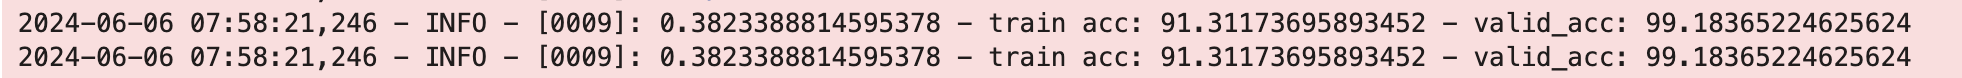